# Modelling and Evaluation Notebook

# Objectives

* Answer Business Requirment 2:
    * The client is interested in predicting the house sale price from her four inherited houses and any other house in Ames, Iowa.

* We will train a machine learning regression model to predict the sale price of inherited houses and other properties in the region.

## Inputs

* outputs/datasets/cleaned/TestSetCleaned.csv
* outputs/datasets/cleaned/TraintSetCleaned.csv
* outputs/datasets/cleaned/clean_inherited_houses.csv
* outputs/datasets/cleaned/clean_house_price_records.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house prices
* Feature Importance Plot
* Model performance plot

## Additional Comments

* The evaluation of the machine learning model guarantees that the predictive model accurately forecasts the sale prices for the client's four inherited homes as well as other properties in Ames, Iowa. 

* Metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared, which measure prediction accuracy and dependability, are used in this procedure to evaluate model performance.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Sales-House-Price-Estimate/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Sales-House-Price-Estimate'

---

# Load Data

In [4]:
import numpy as np
import pandas as pd

df = pd.read_csv('outputs/datasets/collection/house_prices_records.csv')
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


# ML Pipeline: Regressor

* Import libraries for building a machine learning regression pipeline, incorporating feature engineering, preprocessing, and modeling.

In [5]:
from sklearn.pipeline import Pipeline

from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer

from feature_engine import creation
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

**Create ML Pipeline**

* We combine the data cleaning and feature engineering pipelines we created in their respective notebooks.

In [6]:
# Pipeline optimization
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        # Data cleaning (copied from Data Cleaning notebook)
        ('drop', DropFeatures(features_to_drop=['EnclosedPorch','WoodDeckSF'])), 
        ('median', MeanMedianImputer(imputation_method='median', variables=
                                    ['BedroomAbvGr', 'LotFrontage'])),
        ('zero', ArbitraryNumberImputer(arbitrary_number=0, variables=
                                        ['2ndFlrSF', 'MasVnrArea', 'GarageYrBlt'])),
        ('cat', CategoricalImputer(imputation_method='missing', fill_value="None", variables=
                                ['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),

        ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                variables = 
                                                ['BsmtExposure', 'BsmtFinType1',
                                                'GarageFinish', 'KitchenQual'])),
        ('yJt', vt.YeoJohnsonTransformer(variables=
                                        ['OverallQual', 'GrLivArea', 
                                        'GarageArea', 'TotalBsmtSF', '1stFlrSF'])),

        ('rt', vt.ReciprocalTransformer(variables='YearBuilt')),
        ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
                                                variables=['OverallQual','GrLivArea', 
                                                            'GarageArea', 'YearBuilt', 
                                                            'TotalBsmtSF', 'GarageYrBlt', 
                                                            '1stFlrSF', 'YearRemodAdd'])),
        ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables= None,method="spearman", 
                                                            threshold=0.8,selection_method="variance") ),
        ("feat_scaling", StandardScaler()),
        ("feat_selection",  SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for hyperparameter Optimization (*Code Institute Credits)

In [7]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

### Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1) ,
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Grid Search CV - Sklearn

* Use default hyperparameters to find most suitable algorithm

In [9]:
models_quick_search = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42),
}

params_quick_search = {    
    "LinearRegression": {},

    "DecisionTreeRegressor": {
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "RandomForestRegressor": {
        'model__n_estimators': [100, 50, 140],
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 50, 150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
    },

    "AdaBoostRegressor": {
        'model__n_estimators': [50, 25, 80, 150],
        'model__learning_rate': [1, 0.1, 2],
        'model__loss': ['linear', 'square', 'exponential'],
    },

    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 50, 140],
        'model__learning_rate': [0.1, 0.01, 0.001],
        'model__max_depth': [3, 15, None],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "XGBRegressor": {
        'model__n_estimators': [30, 80, 200],
        'model__max_depth': [None, 3, 15],
        'model__learning_rate': [0.01, 0.1, 0.001],
        'model__gamma': [0, 0.1],
    },
}

* We do a hyperparameter optimization search using default hyperparameters.

In [10]:
import warnings
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


* Check results

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__gamma
125,ExtraTreesRegressor,0.76254,0.812938,0.851909,0.038904,15,NaN,1,50,50,NaN,NaN,NaN
101,ExtraTreesRegressor,0.76254,0.812888,0.851657,0.038854,None,NaN,1,50,50,NaN,NaN,NaN
124,ExtraTreesRegressor,0.760752,0.811542,0.848574,0.038821,15,NaN,1,50,100,NaN,NaN,NaN
100,ExtraTreesRegressor,0.760752,0.811538,0.848445,0.038813,None,NaN,1,50,100,NaN,NaN,NaN
102,ExtraTreesRegressor,0.761741,0.811378,0.849787,0.039285,None,NaN,1,50,150,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,XGBRegressor,-6.311047,-5.091572,-4.386755,0.64938,None,NaN,NaN,NaN,30,0.001,NaN,0.1
409,XGBRegressor,-6.311047,-5.091579,-4.386755,0.649377,15,NaN,NaN,NaN,30,0.001,NaN,0
436,XGBRegressor,-6.311047,-5.091579,-4.386755,0.649377,15,NaN,NaN,NaN,30,0.001,NaN,0.1
433,XGBRegressor,-6.312306,-5.092396,-4.387771,0.649532,3,NaN,NaN,NaN,30,0.001,NaN,0.1


* Do extensive search on most suitable model to find best hyperparameter configuration

In [12]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}

* Extensive GridSearch CV

In [13]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


* Check results

In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
27,ExtraTreesRegressor,0.76254,0.812938,0.851909,0.038904,15,1,50,50
3,ExtraTreesRegressor,0.76254,0.812888,0.851657,0.038854,None,1,50,50
28,ExtraTreesRegressor,0.760752,0.811542,0.848574,0.038821,15,1,50,100
4,ExtraTreesRegressor,0.760752,0.811538,0.848445,0.038813,None,1,50,100
5,ExtraTreesRegressor,0.761741,0.811378,0.849787,0.039285,None,1,50,150
29,ExtraTreesRegressor,0.761741,0.811365,0.84987,0.039279,15,1,50,150
26,ExtraTreesRegressor,0.670823,0.783504,0.849822,0.068791,15,1,2,150
2,ExtraTreesRegressor,0.661008,0.782886,0.856795,0.071923,None,1,2,150
0,ExtraTreesRegressor,0.664961,0.782367,0.852977,0.068523,None,1,2,50
25,ExtraTreesRegressor,0.667426,0.782056,0.846229,0.069417,15,1,2,100


* Check the best model

In [15]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

* Parameters for best model

In [16]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

* Define the best estimator from the grid search that achieved the best performance during the grid search process.

In [17]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('median',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'LotFrontage'])),
                ('zero',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea',
                                                   'GarageYrBlt'])),
                ('cat',
                 CategoricalImputer(fill_value='None',
                                    variables=['GarageFinish', 'BsmtFinType1',
                                               'Bsmt...
                                       'GarageYrBlt', '1stFlrSF',
                                       'YearRemodAdd'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=42))),
                ('model',
                 ExtraTreesRegressor(max_depth=15, min_samples_split=50,
                                     n_estimators=50, random_state=42))])

**In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.**
**On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.**

### Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']


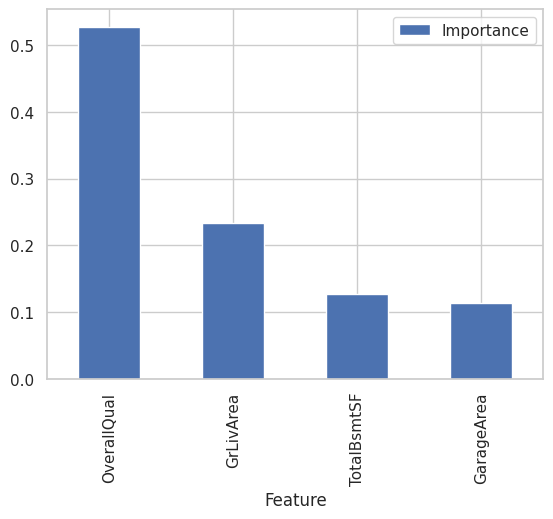

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 9 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps]).transform(X_train).columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False))

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

* Evaluate on Train and Test Sets

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))  
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    plt.savefig(f'images/plots/regression_performance.png', bbox_inches='tight')  
    plt.show()

Evaluate performance of the best regressor pipeline on both training and test sets. This clearly meets the performance indicated in the business case.

Model Evaluation 

* Train Set
R2 Score: 0.836
Mean Absolute Error: 20522.737
Mean Squared Error: 1012440689.159
Root Mean Squared Error: 31818.873


* Test Set
R2 Score: 0.764
Mean Absolute Error: 22562.385
Mean Squared Error: 1626932815.299
Root Mean Squared Error: 40335.255




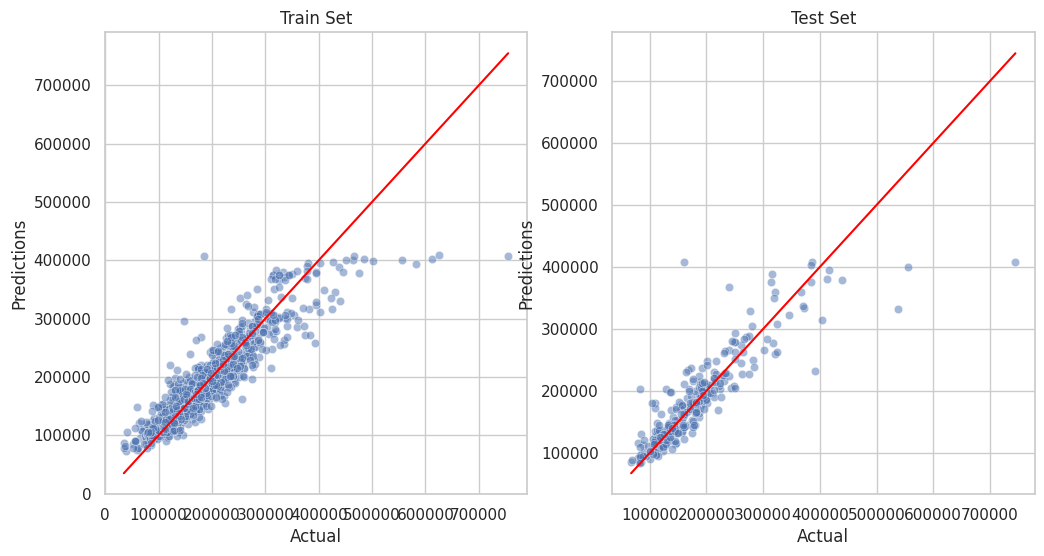

In [23]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

**The regressor pipeline reached the expected performance threshold (0.75 R2 score) for train and test set.**

**R2 for the train and test sets are 0.83 and 0.76 respectively.**
**So our model successfully meets the requirement.**

### Pipeline of the best regressor model

In [24]:
best_regressor_pipeline

Pipeline(steps=[('drop',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('median',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'LotFrontage'])),
                ('zero',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea',
                                                   'GarageYrBlt'])),
                ('cat',
                 CategoricalImputer(fill_value='None',
                                    variables=['GarageFinish', 'BsmtFinType1',
                                               'Bsmt...
                                       'GarageYrBlt', '1stFlrSF',
                                       'YearRemodAdd'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=42))),
                ('model',
                 ExtraTreesRegressor(max_depth=15, min_samples_split=50,
                                     n_estimators=50, random_state=42))])

**In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.**
**On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.**

In [26]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

['GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF']

### Refit pipeline with best features

In [27]:
def PipelineOptimization(model):
    pipeline_base = Pipeline(steps=[  
    ('median', MeanMedianImputer(imputation_method='median', variables=['TotalBsmtSF'])),
    ('zero', ArbitraryNumberImputer(arbitrary_number=0, variables=['GarageArea'])),
        
    ('yJt', vt.YeoJohnsonTransformer(variables=['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'])),
    ("Winsoriser_iqr", Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                                      variables=['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'])),
        
    ("feat_scaling", StandardScaler()),

    ('model', ExtraTreesRegressor(max_depth=15, min_samples_split=50,
                                    n_estimators=50, random_state=0))])        
    return pipeline_base

* Split Train Test Set, only with best features

In [28]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF
618,774,1828,9,1822
870,308,894,5,894
92,432,964,5,876


* Grid Search CV – Sklearn

In [29]:
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=42)}

In [30]:
best_parameters

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

* You will need to type in manually, since the hyperparameter values has to be a list. The previous dictonary is not in this format

In [31]:
params_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [10, 15, 20],
        'model__min_samples_split': [40, 50, 60],
        'model__min_samples_leaf': [1, 2, 3],
    },
}

* GridSearch CV

In [32]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 81 candidates, totalling 405 fits


* Check results

In [33]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
37,ExtraTreesRegressor,0.76978,0.814952,0.854355,0.03685,15,2,40,100
64,ExtraTreesRegressor,0.769587,0.814784,0.854493,0.037181,20,2,40,100
46,ExtraTreesRegressor,0.771675,0.81433,0.850154,0.035066,15,3,40,100
73,ExtraTreesRegressor,0.771622,0.814325,0.850082,0.035088,20,3,40,100
55,ExtraTreesRegressor,0.768287,0.814073,0.851686,0.037396,20,1,40,100
...,...,...,...,...,...,...,...,...,...
69,ExtraTreesRegressor,0.753942,0.804978,0.844516,0.040765,20,2,60,50
42,ExtraTreesRegressor,0.753942,0.804978,0.844516,0.040765,15,2,60,50
24,ExtraTreesRegressor,0.755721,0.80417,0.842253,0.039417,10,3,60,50
51,ExtraTreesRegressor,0.754028,0.803787,0.843143,0.039758,15,3,60,50


* Check the best model

In [34]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

* Define the best clf pipeline

In [35]:
best_pipeline_regressor = grid_search_pipelines[best_model].best_estimator_
best_pipeline_regressor

Pipeline(steps=[('median', MeanMedianImputer(variables=['TotalBsmtSF'])),
                ('zero',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['GarageArea'])),
                ('yJt',
                 YeoJohnsonTransformer(variables=['OverallQual', 'GrLivArea',
                                                  'GarageArea',
                                                  'TotalBsmtSF'])),
                ('Winsoriser_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['OverallQual', 'GrLivArea', 'GarageArea',
                                       'TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=15, min_samples_leaf=2,
                                     min_samples_split=40, random_state=0))])

**In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.**
**On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.**

# Push files to the repo

In [36]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

* Train Set : features and target

In [37]:
X_train.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF
618,774,1828,9,1822
870,308,894,5,894
92,432,964,5,876
817,857,1689,8,1568
302,843,1541,7,1541


In [38]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

* Test Set: features and target

In [39]:
X_test.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF
529,484,2515,6,2035
491,240,1578,6,806
459,352,1203,5,709
279,505,2022,7,1160
655,264,1092,6,525


In [40]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

**Modelling pipeline**
* ML pipeline for predicting tenure

In [41]:
best_pipeline_regressor

Pipeline(steps=[('median', MeanMedianImputer(variables=['TotalBsmtSF'])),
                ('zero',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['GarageArea'])),
                ('yJt',
                 YeoJohnsonTransformer(variables=['OverallQual', 'GrLivArea',
                                                  'GarageArea',
                                                  'TotalBsmtSF'])),
                ('Winsoriser_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['OverallQual', 'GrLivArea', 'GarageArea',
                                       'TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=15, min_samples_leaf=2,
                                     min_samples_split=40, random_state=0))])

**In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.**
**On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.**

In [42]:
joblib.dump(value=best_pipeline_regressor, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/predict_price/v1/regression_pipeline.pkl']

**Feature importance plot**

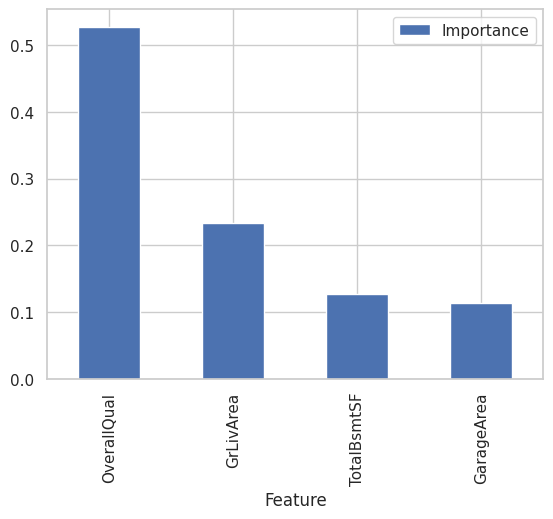

In [43]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

* Create a bar plot for feature importance and saves it as images in two specified locations.

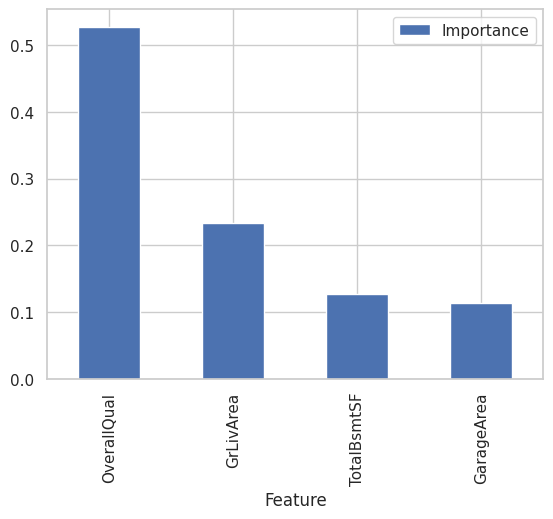

In [45]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')
plt.savefig(f'images/plots/features_importance.png', bbox_inches='tight') 

# Conclusions

* The feature importance plot reveals and confirms our initial hypotheses: 

   * Houses with higher overall material and finish quality ```OverallQual``` sell for higher prices.

   * Houses with larger above-ground living area ```GrLivArea``` have higher sale prices.

   * Houses with extra spaces get to a higher sale price, and here we can include ```TotalBsmtSF``` and ```GarageArea```.

   * ```KitchenQual``` didn't come up in our best variables, but we don't disqualify the power this can have on predicting the ```SalePrice```.

* The predictive model, ExtraTreesRegressor, balances bias and variance by using an ensemble approach with controlled depth and sample splits. 

* The pipeline seeks to reduce the influence of outliers and skewed distribution while improving prediction accuracy and robustness through these carefully chosen steps. 

* Given the favorable evaluation ratings, it is clear that this model meets the performance objectives stated in the business case.